In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
import os
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
import pandas as pd
from itertools import islice
import copy

C:\Users\CherWei\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set up variables for constants such as absolute datapaths and the desired valdiation fraction split.

In [2]:
classyfire_datapath = "G:\\Dev\\Data\\For Substituent GNPS ALL\\GNPS Python Master\\Final Data.txt"
substituents_path = "G:\\Dev\\Data\\Classyfire Taxanomy\\GNPS_substituents.txt"
synced_substituents_path = "G:\\Dev\\Data\\Classyfire Taxanomy\\GNPS_synced_substituents.txt"
substituents_names_path = "G:\\Dev\\Data\\Classyfire Taxanomy\\GNPS_substituents_legend.txt"
filtered_substituents_names_path = "G:\\Dev\\Data\\filtered_top_substituents_after_parameters_legend.txt"
substituents_auc_results_path = "G:\\Dev\\Data\\Classyfire Taxanomy\\substituents_auc_results.txt"
num_samples = 9238
numSubstituents = 381
val_fraction = 0.1
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1


The below are methods used to load in fragment spectra and fingerprint data from files stored in the absolute paths specified above.

In [3]:
# Loads a master file containing peak intensities for all molecules.
# Each molecule's spectrum is added as a 1000 element row to a Pandas dataframe
# The dataframe is then converted into a numpy array for use as Keras Input.
# Include the option of adding additonal features to each molecule (mass_shifts variable)
def load_master_file(path, mass_shifts = 0, number_of_bins = 1000):
    MAX_MASS = 1000
    BIN_SIZE = 1
    NUM_FEATURES = mass_shifts
    mol_all = np.loadtxt(path, dtype="U30") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range((number_of_bins//BIN_SIZE)+NUM_FEATURES), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], float(row[1])-1] = float(row[2])
    
    # Convert populated dataframe into a numpy array for use by neural networks.
    np_matrix = intensities.values
    return np_matrix

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_substituents_master(path):
    BITS = 89  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U30") # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    substituents = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        substituents.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    
    np_matrix = substituents
    return np_matrix

# Load the names of all substituents included in the correct order
# This is used for boxplots, when performance metrics for individual substituent are calculated.
def load_substituent_legend(path):
    substituent_legend = []
    # Open file containing substituent names.
    with open(path, 'r') as f:
        # Add each name to the list of substituent names.
        lines = list(islice(f, 0, None))
        for line in lines:
            substituent_legend.append(line[:-1])
    return substituent_legend


The below methods create and train various neural networks when provided with valid input and output data. They allow for specifying the number of epochs the network is to be trained for and, in some cases, the learning rate. Trained models are returned and can be used to predict on test data and thereby be evaluated.

In [9]:
# Import Sotchastic Gradient Descent object from Keras to allow for tweaking its learning rate.
from keras.optimizers import SGD

# A simplified spectrum-fingeprrint encoder.
# Structure: (Input)1000-500-200-2098(Output)
def simplified_substituent_model(x_train_spectra, x_train_substituents, epochs=100):
    # Create input based on the provided x_train data structure.
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    # Since output is not the same as input, we obtain its shape separately.
    output_dims = x_train_substituents.shape[1]
    print(output_dims)
    # Create the encoding layers using functional API.
    l = input_layer
    l = Dense(500, activation='relu')(l)
    
    # Linear activation ensures that values can be negative (necessary for sigmoid to function)
    l = Dense(200, activation='linear')(l)
    
    # Save reference to latent space
    latent_space = l
    
    # Sigmoid activation to get outputs between 0 and 1. This is done because the output fingerprint is a set of bits (0 or 1).
    l2 = Dense(output_dims, activation='sigmoid')(l)
    
    #Reference for output layer
    out_layer = l2

    auto_model = Model(input=input_layer, output=out_layer)
    
    # Set SGD learning rate = 0.05 and compile model with binary_crossentropy as loss function.
    sgd = SGD(lr=0.05)
    auto_model.compile(loss='binary_crossentropy', optimizer=sgd)
    
    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_substituents, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    # Loss Plots
    plot_loss(autoencoder_train, epochs)
    
    return auto_model # Return model, now trained

In [10]:
# This function takes as input a trained neural network model and extracts its history variable.
# It then uses it to graph the model's loss and validation loss over the training epochs
# The epochs paramter is used for plotting the x axis.
def plot_loss(fitted_model, epochs):
    # Extract loss values for the training and validation sets.
    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']
    # Create x axis variables.
    epochs_label = epochs
    epochs = range(epochs)

    #Plot both losses.
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss,'r', label='Validation loss')
    plt.title('Training and Validation Loss for ' + str(epochs_label) + ' epochs')
    plt.legend()
    plt.show()
    
# Takes a actual and predicted fingerprint values and computes the area under the Roc curve for each substructure.
# For each subtructure, also calculates AUC when the actual values are scrambled.
# Return two numpy arrays: one containing AUC metrics for all susbtructures, one containing each permutation's
# AUC scores for each susbtructure.
from sympy.utilities.iterables import multiset_permutations
def compute_auc(bits, true, pred, num_samples=0, permutations=500):
    val_start_index = int(num_samples-(num_samples*val_fraction)-1) # Index where validation samples begin.
    
    num_permutations = permutations  # Number of permutations to compute AUC scores for. 
    
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int),('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)

    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((bits, num_permutations))
    val_start_index = 0
    for fp_id in range(true.shape[1]): # For every substructure
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Compute AUC scores for permutations and compare to actual.
            counter = 0         
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                # Count how many permutations have a higer AUC score than actual data.
                if perm_score >= score:
                    counter = counter + 1
            # Calculate % of scrambled values with higher AUC score than actual AUC
            percentage = (counter/num_permutations)*100
        # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)
        
    # Permutations take a while, print statement to say when finished.
    print("Compute AUC Done")
    return mol_stats, perm_scores


# Takes a set of AUC scores and permutation AUC scores (normally output by compute_auc above) an uses them
# to draw boxplots for specified susbtructures. Actual AUC is plotted as a coloured dot.
plt.rcParams['figure.dpi'] = default_dpi*2.2
def boxplots(real_stats, perm_stats, sample_fps):
    index = sample_fps['fp_id']  # Grab id of each substructure to be plotted, used as index in parallel arrays
    names = np.array(substituent_names)[index]  # Grab name of each susbtructure to be plotted.

    plt.rcParams.update({'font.size': 6})
    plt.figure()
    plt.boxplot(perm_stats[index].T, vert=False, labels = names) # Boxplot permutation AUC scores
    plt.scatter(real_stats[index]['auc'], range(1, len(index)+1)) # Scatter plot actual AUC scores for substructures in colour.
    plt.show()

    
# Takes a set of AUC scores and permutation AUC scores and uses them to draw boxplots for specified substructures
# Actual AUC is plotted as a coloured dot. A separate set of AUC scores
# computed for prediction from a different model is also plotted for comparison
def tandem_boxplots(real_stats, perm_stats, exp_stats, sample_fps):
    index = sample_fps['fp_id']  # Grab id of each substructure to be plotted, used as index in parallel arrays
    names = np.array(substituent_names)[index]  # Grab name of each susbtructure to be plotted.
  
    plt.rcParams.update({'font.size': 6})
    plt.figure()
    plt.boxplot(perm_stats[index].T, vert=False, labels = names) # Boxplot permutation AUC scores
    plt.scatter(real_stats[index]['auc'], range(1, len(index)+1)) # Scatter plot actual AUC scores for substructures
    plt.scatter(exp_stats[index]['auc'], range(1, len(index)+1), color = 'r') # Scatter plot AUC scores to be compared to.
    plt.show()


# Given the AUC statistics derived from two separate models, it comapres the two models' performance
# Creates a bar chart comparing substructures above an AUC threshold and draws boxplots for each model's best and worst
# performing substructures.
# Usually compares an experimental model's AUC to a baseline (e.g. the basic fingerprint encoder)
def evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores):
    # Sort molecules in ascending order of baseline AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((base_stats['auc'] > 0.5))
    abnormal_auc = np.where((base_stats['auc']) < 0.5)
    ordered_base = np.sort(base_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_base[:30]
    sample_fps = np.append(sample_fps, ordered_base[-5:])
    
    # Plot number of substructures with AUC scores above 0.7 and above 0.5 for both data sets
    base_above_07 = len(np.where((base_stats['auc'] >= 0.7))[0])
    exp_above_07 = len(np.where((exp_stats['auc'] >= 0.7))[0])
    base_above_05 = len(np.where((base_stats['auc'] >= 0.5))[0])
    exp_above_05 = len(np.where((exp_stats['auc'] >= 0.5))[0])
    
    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.5
    ax.bar(index, (base_above_05, base_above_07), bar_width, alpha=opacity, color='b', label='Baseline')
    ax.bar(index+bar_width, (exp_above_05, exp_above_07), bar_width, alpha=opacity, color='r', label='Experiment')
    
    ax.set_xlabel('AUC Threshold')
    ax.set_ylabel('Number of Substituents')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Above 0.5', 'Above 0.7'))
    ax.legend()
    
    plt.show()
    
    # Boxplots of sample substructures for both data sets
    boxplots(base_stats, base_perm_scores, sample_fps)
    boxplots(exp_stats, exp_perm_scores, sample_fps)
    tandem_boxplots(base_stats, base_perm_scores, exp_stats, sample_fps)
    
     # Sort molecules in ascending order of experimental AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((exp_stats['auc'] > 0.5))
    abnormal_auc = np.where((exp_stats['auc']) < 0.5)
    ordered_exp = np.sort(exp_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_exp[:30]
    sample_fps = np.append(sample_fps, ordered_exp[-5:])
    
    boxplots(base_stats, base_perm_scores, sample_fps)
    boxplots(exp_stats, exp_perm_scores, sample_fps)
    tandem_boxplots(base_stats, exp_perm_scores, exp_stats, sample_fps)
    

# Given a matrix of layer weights, plots them in a Hinton diagram: each weight is a box
# Box size is indicates absolute value, box colour indicates sign (white for positive, black for negative)
# Adapted from matplotlib documentation.
def hinton(matrix, max_weight=None, ax=None):
    ax = ax if ax is not None else plt.gca()
    # Find maximum weight in matrix.
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    # Plot weights as black or white boxes.
    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

The following methods are quick ways to train multiple times using different training-validation splits. Used when we want means, error bars and statistical tests for model comparisons.

In [11]:
# Trains the basic substituent encoder using 10 different validation-training splits.
# Computes AUC scores for each split and stores them as a separate file.
# Takes path to store files in as a parameter, as well as the name of the test.
def train_diff_splits(path, name, splits=10):
    # Extract permuted indices for dataset.
    index_path = "G:\\Dev\\Data\\GNPS ALL Substituent Validation Split Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 100
    path = path + name + " "
    #List to store AUC scores if we want to use them right away instead of loading from files.
    experiment_stats = []
    for i in range(splits):
        # Create filepath for this training session.
        curr_path = path + str(i) + ".txt"
        # Use permuted indices to create permuted array of input data.
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        x_train_substituents = substituents.values[permuted_indices[:, i]]
        # Train a basic model.
        enc_basic = simplified_substituent_model(x_train_dense, x_train_substituents, epochs=100)
        # Use trained model to compute AUC scores for substructures and save them to disc.
        actual = x_train_substituents
        predicted = enc_basic.predict(x_train_dense)
        base_stats, base_perm_scores = compute_auc(2098, actual, predicted, num_samples=10038)
        
        np.savetxt(curr_path, base_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(base_stats)
    
    evaluate(base_stats, base_perm_scores, base_stats, base_perm_scores)
    
    return experiment_stats



The below is the basic set up for running any of the methods. It loads the fragment spectra and subtituent terms

In [12]:
spectra = load_master_file(path=classyfire_datapath)
substituents = load_substituents_master(synced_substituents_path)
substituent_names = load_substituent_legend(filtered_substituents_names_path)
print("Done")

Done


89


C:\Users\CherWei\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 9034 samples, validate on 1004 samples
Epoch 1/100
9034/9034 [==============================] - 3s 319us/step - loss: 0.3603 - val_loss: 0.2500
Epoch 2/100
9034/9034 [==============================] - 3s 277us/step - loss: 0.2719 - val_loss: 0.2381
Epoch 3/100
9034/9034 [==============================] - 3s 278us/step - loss: 0.2583 - val_loss: 0.2311
Epoch 4/100
9034/9034 [==============================] - 3s 279us/step - loss: 0.2483 - val_loss: 0.2254
Epoch 5/100
9034/9034 [==============================] - 2s 277us/step - loss: 0.2398 - val_loss: 0.2205
Epoch 6/100
9034/9034 [==============================] - 3s 283us/step - loss: 0.2325 - val_loss: 0.2164
Epoch 7/100
9034/9034 [==============================] - 3s 376us/step - loss: 0.2265 - val_loss: 0.2129
Epoch 8/100
9034/9034 [==============================] - 3s 327us/step - loss: 0.2215 - val_loss: 0.2100
Epoch 9/100
9034/9034 [==============================] - 3s 354us/step - loss: 0.2172 - val_loss: 0.2075
Epoch 1

9034/9034 [==============================] - 2s 273us/step - loss: 0.1279 - val_loss: 0.1848
Epoch 78/100
9034/9034 [==============================] - 2s 271us/step - loss: 0.1270 - val_loss: 0.1850
Epoch 79/100
9034/9034 [==============================] - 2s 271us/step - loss: 0.1261 - val_loss: 0.1852
Epoch 80/100
9034/9034 [==============================] - 3s 293us/step - loss: 0.1253 - val_loss: 0.1853
Epoch 81/100
9034/9034 [==============================] - 3s 277us/step - loss: 0.1244 - val_loss: 0.1855
Epoch 82/100
9034/9034 [==============================] - 2s 275us/step - loss: 0.1235 - val_loss: 0.1857
Epoch 83/100
9034/9034 [==============================] - 2s 274us/step - loss: 0.1227 - val_loss: 0.1859
Epoch 84/100
9034/9034 [==============================] - 2s 271us/step - loss: 0.1218 - val_loss: 0.1861
Epoch 85/100
9034/9034 [==============================] - 2s 271us/step - loss: 0.1210 - val_loss: 0.1863
Epoch 86/100
9034/9034 [==============================] - 3

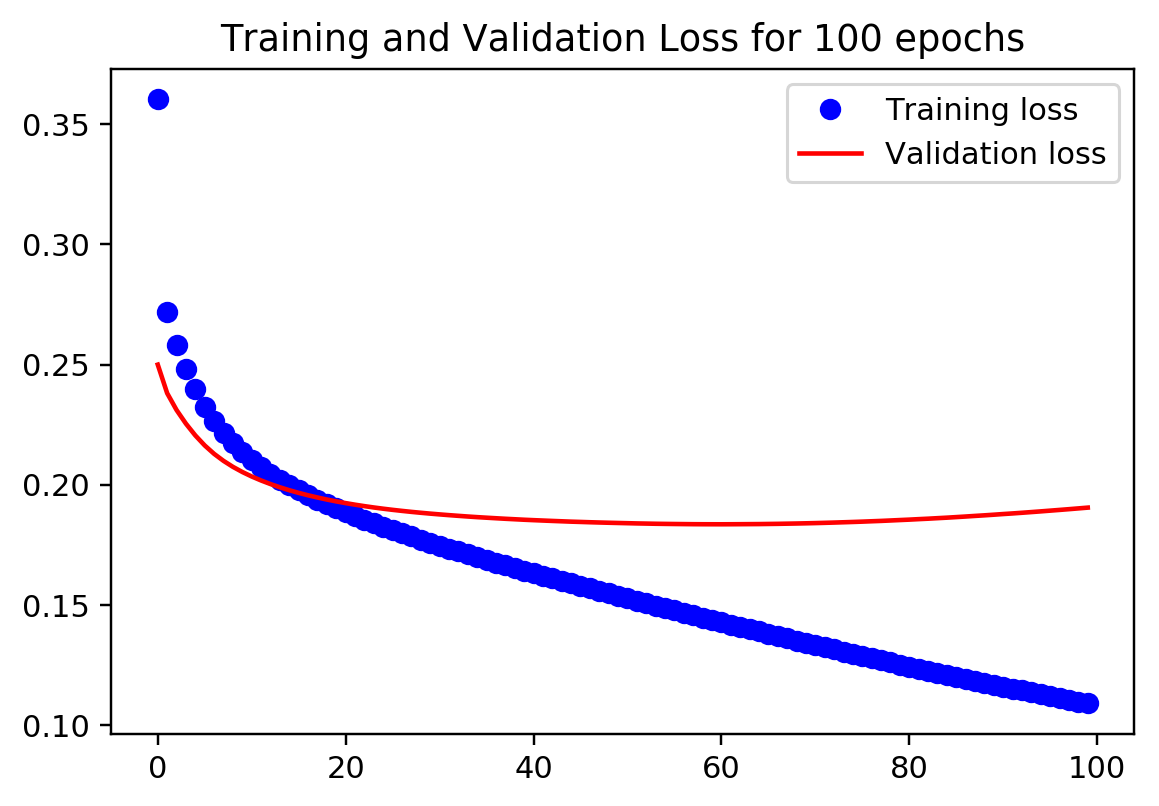

Compute AUC Done
(array([( 0,   880, 0.72707059, 0.), ( 1, 10008, 0.77722655, 0.),
       ( 2,  2062, 0.92408357, 0.), ( 3,  8767, 0.8523612 , 0.),
       ( 4,  4299, 0.93282478, 0.), ( 5,  2702, 0.89130091, 0.),
       ( 6,  5623, 0.8723108 , 0.), ( 7,   432, 0.96832444, 0.),
       ( 8,  1855, 0.98342593, 0.), ( 9,   824, 0.94483213, 0.),
       (10,  3509, 0.94498566, 0.), (11,  5269, 0.91362448, 0.),
       (12,  4760, 0.94603318, 0.), (13,  1019, 0.94776701, 0.),
       (14,  1500, 0.99507512, 0.), (15,   419, 0.97665197, 0.),
       (16,  1958, 0.96505903, 0.), (17,  1815, 0.97231839, 0.),
       (18,  4939, 0.93804555, 0.), (19,  3346, 0.92116659, 0.),
       (20,  3701, 0.95757138, 0.), (21,  5238, 0.98705873, 0.),
       (22,  4712, 0.95536874, 0.), (23,  5230, 0.98696896, 0.),
       (24,  4118, 0.94374768, 0.), (25,  2145, 0.91981252, 0.),
       (26,  1486, 0.98950007, 0.), (27,  1092, 0.92419177, 0.),
       (28,  2205, 0.91132574, 0.), (29,  1225, 0.92669493, 0.),
       

In [13]:
# Train 1 time

epochs = 100
x_train_spectra = np.log(spectra+1)
x_train_substituents = substituents

enc = simplified_substituent_model(x_train_spectra, x_train_substituents.values, epochs=epochs)

actual = x_train_substituents.values
predicted = enc.predict(x_train_spectra)

print(compute_auc(89, actual, predicted, num_samples=10038))
    
print("Done")

Comparing base scores with experiment scores (to get the bar chart)

In [ ]:
evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores)

Write the results in (substituent_term auc_score) format to a file

In [ ]:
with open(substituents_auc_results_path, 'w') as f:
    for index, auc in enumerate(exp_stats):
        f.write(substituent_names[index] + " " + str(auc[2]) + "\n")

Method to calculate how many matches are there i.e. true label == predicted label. Write to result to a file

In [ ]:
substituent_dict = {}
true_label_counter = {}
substituent_correct_counter = {}

for name in substituent_names:
    true_label_counter[name] = 0
    substituent_correct_counter[name] = 0

# save the substituent terms indexes to a dict for each id
# e.g. {CCMSLIB0000001 : [10, 15, 103], ...}
with open(substituents_path, 'r') as f:
    for line in f:
        id, index, value = line.split(" ")
        if id not in substituent_dict:
            substituent_dict[id] = []
        substituent_dict[id].append(index)

# get the index of element that has highest probability
# for each substituent terms in the gnps id, store the max
# in the end, go through each and see if the index is in the true labels
# if matches, that term's counter increase
for index, probabilities in enumerate(predicted):
    temp = copy.deepcopy(probabilities).tolist()
    true_labels = []
    max_indexes = []
    for substituent_index in substituent_dict[substituents.index[index]]:
        true_labels.append(substituent_index)
        max_index = temp.index(max(temp))
        max_indexes.append(max_index)
        temp.remove(temp[max_index])
        true_label_counter[substituent_names[int(substituent_index)]] += 1
    for index in max_indexes:
        if index in true_labels:
            substituent_correct_counter[substituent_names[int(index)]] += 1
                    
prediction_comparison_report_path = "G:\\Dev\\Data\\substituent_prediction_comparison_report.txt"
with open(prediction_comparison_report_path, 'w') as f:
    f.write("substituent,matched,actual,proportion\n")

with open(prediction_comparison_report_path, 'a') as f:
    for substituent in substituent_correct_counter:
        matched = substituent_correct_counter[substituent]
        actual = true_label_counter[substituent]
        proportion = 0
        if actual != 0:
            proportion = matched / actual
        f.write(substituent + "," + str(matched) + "," + str(actual) + "," + str(proportion*100) + "\n")

Method to generate validation split files to be used when training different splits 10 times

In [ ]:
gnps_all_substituent_perm_file_path = "G:\\Dev\\Data\\GNPS ALL Substituent Validation Split Permutations.txt"

# Create and store 10 randomly permuted indices for 10038 samples
sample_size = 10038
att = np.arange(sample_size)

att = np.random.permutation(att)

index_permutations = np.zeros((sample_size, 0), dtype=int)
# Add each permutation to a numpy array of indices
for i in range(10):
    perm = np.random.permutation(np.arange(sample_size, dtype=int))
    index_permutations = np.column_stack((index_permutations, perm))

# Verify numpy array has correct shape (should be 5770 for each column)
for i in range(10):
    print(np.unique(index_permutations[:, i]).size)

# Save index permutations to file
np.savetxt(gnps_all_substituent_perm_file_path, index_permutations, delimiter=',', fmt='%d')

Example of training 10 times

In [39]:
# Train 10 times (may take awhile)

path = "G:\\Dev\\Data\\Substituents Experiments\\"
train_diff_splits(path, "GNPS ALL Substituents")

process_average_substituent_path = "G:\\Dev\\Data\\Substituents Experiments\\filtered_average_result.txt"
substituents_legend_path = "G:\\Dev\\Data\\Classyfire Taxanomy\\GNPS_substituents_legend.txt"
substituents_term_occurences_path = "G:\\Dev\\Data\\Substituent Terms Occurences\\substituents_terms_occurences.txt"
variables = ["GNPS ALL Substituents"]
data = []
substituent_occurences_dict = {}

# to calculate occurences
with open(substituents_legend_path, 'r') as f:
    content = f.readlines()

with open(substituents_term_occurences_path, 'r') as f:
    for line in f:
        substituent, occurences = line.split("\t")
        substituent_occurences_dict[substituent] = int(float(occurences[:-1]))

for i in range(10):
    filepath = path + variables[0] + " " + str(i) + ".txt"
    stats_one = np.loadtxt(filepath, dtype=float)
    print(stats_one[:, 2])
    data.append(stats_one[:, 2])

print("Average")
result = np.mean(data, axis=0)
with open(process_average_substituent_path, 'w') as f:
    for index, probability in enumerate(result):
        f.write(content[index][:-1] + "\t" + str(probability) + "\t" + str(substituent_occurences_dict[content[index][:-1]]) + "%\n")

HI


Saving model to h5 format

In [14]:
filepath = "G:\\Dev\\Data\\saved_substituents_classifier_after_parameters_model.h5"
enc.save(filepath)
